# Ray Tracing: Ray Tracing Pipelines

Vulkan provides two methods of ray tracing which may be supported by a device
independently. Ray tracing pipelines are the more powerful, but also more complex
variant. We assume you are already familiar with these and only show how to use
them with hephaistos. Check the Vulkan API documentation/specification for an
explanation of ray tracing pipelines in general.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hephaistos as hp
from ctypes import *

rtFeatures = hp.RayTracingFeatures(pipeline=True)
assert hp.isRayTracingSupported(rtFeatures), "Ray tracing pipelines are not supported!"
hp.enableRayTracing(rtFeatures)

Similar to the ray query example, we start with creating the acceleration structure

In [2]:
from stl.mesh import Mesh
mesh_file = Mesh.from_file("./monkey.stl")
vertices = np.reshape(mesh_file.vectors, (-1, 3))

mesh = hp.Mesh()
mesh.vertices = vertices

store = hp.GeometryStore([mesh])

instance = store.createInstance(0)
accStruct = hp.AccelerationStructure([instance])

## Creating Ray Tracing Pipeline

Ray tracing pipelines consist of multiple shaders.
To keep the example simple, we will create a minimalistic ray tracing pipeline.

First we have to compile each stage independently.

In [3]:
compiler = hp.Compiler()

In [4]:
rayGenSource = """
#version 460
#extension GL_EXT_ray_tracing : require

layout(location = 0) rayPayloadEXT vec3 payload;

layout(binding = 0) uniform accelerationStructureEXT tlas;
layout(binding = 1, rgba8) uniform image2D outImage;

void main() {
    vec2 size = vec2(imageSize(outImage));
    vec2 pos = vec2(gl_LaunchIDEXT.xy);
    vec2 coord = pos / size * 2 - vec2(1.0, 1.0);

    //to things a bit more simple, we render orthogonal in y direction
    //image is in the xz plane; flip y as usual
    vec3 start = vec3(coord.x, -2.0, -coord.y);
    vec3 dir = vec3(0.0, 1.0, 0.0);

    //default value for payload as we won't have a miss shader
    payload = vec3(0.106, 0.322, 0.282);

    traceRayEXT(
        tlas,
        gl_RayFlagsOpaqueEXT, 0xFF,
        0, 0, 0,
        start, 0.0,
        dir, 4.0,
        0
    );

    imageStore(outImage, ivec2(gl_LaunchIDEXT.xy), vec4(payload, 1.0));
}
"""
rayGenCode = compiler.compile(rayGenSource, stage=hp.ShaderStage.RAYGEN)

In [5]:
hitSource = """
#version 460
#extension GL_EXT_ray_tracing : require

layout(location = 0) rayPayloadInEXT vec3 payload;

void main() {
    payload = vec3(1.0 - 0.5 * (gl_HitTEXT - 1.0));
}
"""
hitCode = compiler.compile(hitSource, stage=hp.ShaderStage.CLOSEST_HIT)

With all shaders compiled we can create the ray tracing pipeline

In [6]:
pipeline = hp.RayTracingPipeline([
    hp.RayGenerateShader(rayGenCode),
    hp.RayHitShader(closest=hitCode),
])

Create the missing argument and bind everything to the pipeline

In [7]:
buffer = hp.ImageBuffer(2048, 2048)
image = hp.Image(hp.ImageFormat.R8G8B8A8_UNORM, 2048, 2048)
pipeline.bindParams(tlas=accStruct, outImage=image)

## Tracing Rays

Before we can actually traces rays, we are still missing the shader binding tables
telling the pipeline what shaders to use. Let's quickly create them

In [8]:
# we bundle the SBTs this way into a dict, so we can easily use it when tracing rays
sbt = {
    "rayGenShaders": pipeline.createShaderBindingTableRange(0),
    "missShaders": pipeline.createShaderBindingTable([None]),
    "hitShaders": pipeline.createShaderBindingTableRange(1),
}

Finally, we have everything we need to trace some rays. So let's do that.

In [9]:
hp.beginSequence().And(pipeline.traceRays(2048, 2048, **sbt)).Then(hp.retrieveImage(image, buffer)).Submit().wait()

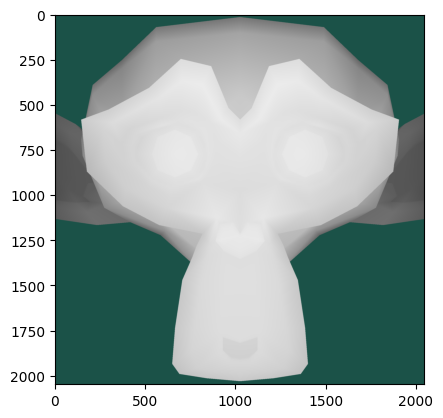

In [10]:
plt.imshow(buffer.numpy())
plt.show()